Homework 4: Reaction-Diffusion - Bryssinck Paul & de Becker Alexandre

Le but de ce quatrième devoir est d'étudier le phénomène de réaction-diffusion à l'aide du modèle de Gray Scott. Nous avons un milieu avec des particules u et v. Celui-ci est continument nourri de particules u, lorsque 2 particules v rencontrent une particule u, la particule u est convertie en particule u et des particules v sont constament retirées. Ces trois conditions sont données par les deux équations suivantes:

$\frac{\partial u}{\partial t}= D_u \nabla^2 u-uv^2+F(1-u)$

$\frac{\partial v}{\partial t}=D_v \nabla^2v+uv^2-(F+k)v$

Pour le bord de notre domaine nous allons utiliser des conditions de Neumann données par:

$q_x=q_y=0$

Pour commencer notre code, nous importons les outils nécessaires.

In [1]:
import numpy
import matplotlib as plt
from matplotlib import pyplot
import matplotlib.cm as cm
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

Pour les conditions initiales pour les particules u et v, nous chargeons un fichier nous les donnant.

In [2]:
uvinitial = numpy.load('./uvinitial.npz')
U = uvinitial['U']
V = uvinitial['V']

Dans les deux équations de départ que nous avions, nous pouvons faire varier les valeurs de Du, Dv, F et k. Ceci va nous donner des résultats variés et avec des aniamtions nous pouvons voir des desseins pouvant rappeler des modèles de tous les jours. 

Du, Dv, F, k = 0.00016, 0.00008, 0.035, 0.065  Bacteria 1

Du, Dv, F, k = 0.00014, 0.00006, 0.035, 0.065  Bacteria 2

Du, Dv, F, k = 0.00016, 0.00008, 0.060, 0.062  Coral

Du, Dv, F, k = 0.00019, 0.00005, 0.060, 0.062  Fingerprint

Du, Dv, F, k = 0.00010, 0.00010, 0.018, 0.050  Spirals

Du, Dv, F, k = 0.00012, 0.00008, 0.020, 0.050  Spirals Dense

Du, Dv, F, k = 0.00010, 0.00016, 0.020, 0.050  Spirals Fast

Du, Dv, F, k = 0.00016, 0.00008, 0.020, 0.055  Unstable

Du, Dv, F, k = 0.00016, 0.00008, 0.050, 0.065  Worms 1

Du, Dv, F, k = 0.00016, 0.00008, 0.054, 0.063  Worms 2

Du, Dv, F, k = 0.00016, 0.00008, 0.035, 0.060  Zebrafish

Ici nous allons nous étudier le cas "Bacteria 1". Nous entrons alors les valeurs de Du, Dv, F et k respectives. Nous entrons aussi les valeurs n, qui sera le nombre de point pour chacun de nos deux coté (ce qui nous fera une grille de 192x192 points), dh, qui est le pas entre chaque point (ici expimé comme étant la taille d'un coté divisé par n-1), T qui est notre temps final, dt qui est donné par $dt=\frac{9}{40}\frac{dh^2}{max(Du,Dv)}$ et nt qui est le temps total divisé par le pas de temps arrondi à l'entier et qui sera donc le nombre de pas de temps.

In [3]:
n = 192
Du, Dv, F, k = 0.00016, 0.00008, 0.035, 0.065 # Bacteria 1
dh = 5./(n-1)
T = 8000
dt = .9 * dh**2 / (4*max(Du,Dv))
nt = int(T/dt)

Nous pouvons à présent nous attaquer au code principale. Nous commençons par créer U et V qui seront nos densités de particules u et v respectivement, en tout point de la matrice. Nous démarons avec U et V ayant les valeurs du fichier chargé plus haut. Nous créons ensuite Usave et Vsave afin de pouvoir garder les valeurs de U et de V à chaque instant et dont les premières valeurs prendront celles de U et V initiales. Ensuite pour chaque temps, nous créons des copies de U et de V afin de garder les valeurs du temps précédent tout le long du calcul. Ensuit nous calculons les valeurs de U et V, en commançant par les valeurs du centre de notre grille et ensuite celles du bord. Avant de passer au temps suivant on enregistre la valeur de U et de V dans Usave et Vsave. 

Pour calculer le centre du milieu, nous avons utilisé les deux équations de Gray Scott que nous avions au début et nous les avons discrétisées de manière forward pour le temps et centrale pour l'espace. Ce qui nous donne les deux équations suivantes:

$\frac{u_{x,y}^{n+1}-u_{x,y}^n}{\Delta t}=D_u((\frac{u_{x+1,y}^n-2u_{x,y}^n+u_{x-1,y}}{\delta^2})+(\frac{u_{x,y+1}^n-2u_{x,y}^n+u_{x,y-1}^n}{\delta^2}))-u_{x,y}^n(v_{x,y}^n)^2+F(1-u_{x,y}^n)$

$\frac{v_{x,y}^{n+1}-v_{x,y}^n}{\Delta t}=D_v((\frac{v_{x+1,y}^n-2v_{x,y}^n+v_{x-1,y}}{\delta^2})+(\frac{v_{x,y+1}^n-2v_{x,y}^n+v_{x,y-1}^n}{\delta^2}))+u_{x,y}^n(v_{x,y}^n)^2-(F+k)v_{x,y}^n$

En isolant dans chacune d'elle le terme qui nous interresse, nous obtenons alors:

$u_{x,y}^{n+1}=\Delta t(D_u((\frac{u_{x+1,y}^n-2u_{x,y}^n+u_{x-1,y}}{\delta^2})+(\frac{u_{x,y+1}^n-2u_{x,y}^n+u_{x,y-1}^n}{\delta^2}))-u_{x,y}^n(v_{x,y}^n)^2+F(1-u_{x,y}^n))+u_{x,y}^n$

$v_{x,y}^{n+1}=\Delta t (D_v((\frac{v_{x+1,y}^n-2v_{x,y}^n+v_{x-1,y}}{\delta^2})+(\frac{v_{x,y+1}^n-2v_{x,y}^n+v_{x,y-1}^n}{\delta^2}))+u_{x,y}^n(v_{x,y}^n)^2-(F+k)v_{x,y}^n)+v_{x,y}^n $

(Dans notre code $\Delta t$ sera dt et $\delta$ sera dh)

En ce qui concerne les bord de la grille, nous avons simplement que les valeurs sont celles qui se trouvaient juste à coté (c'est-à-dire juste un cran vers le centre) au temps précédent.

Tout ça se traduit sous la forme de code comme suit: 

In [4]:
U = uvinitial['U']
V = uvinitial['V']
Usave=numpy.zeros((8302,192,192))
Vsave=numpy.zeros((8302,192,192))
Usave[0,:,:]=U[:,:]
Vsave[0,:,:]=V[:,:]

for t in range(nt):
    Uc=U.copy()
    Vc=V.copy()
    
      
    U[1:-1,1:-1]=dt*(Du*((Uc[2:,1:-1]-2*Uc[1:-1,1:-1]+Uc[:-2,1:-1]\
                         +Uc[1:-1,2:]-2*Uc[1:-1,1:-1]+Uc[1:-1,:-2])/dh**2)\
                         -(Uc[1:-1,1:-1]*(Vc[1:-1,1:-1])**2)+F*(1-Uc[1:-1,1:-1]))+Uc[1:-1,1:-1]                
    V[1:-1,1:-1]=dt*(Dv*((Vc[2:,1:-1]-2*Vc[1:-1,1:-1]+Vc[:-2,1:-1]\
                         +Vc[1:-1,2:]-2*Vc[1:-1,1:-1]+Vc[1:-1,:-2])/dh**2)\
                         +(Uc[1:-1,1:-1]*(Vc[1:-1,1:-1])**2)-Vc[1:-1,1:-1]*(F+k))+Vc[1:-1,1:-1]
    
    
    
    U[:,0]=U[:,1]
    U[:,-1]=U[:,-2]
    U[0,:]=U[1,:]
    U[-1,:]=U[-2,:]
    V[:,0]=V[:,1]
    V[:,-1]=V[:,-2]
    V[0,:]=V[1,:]
    V[-1,:]=V[-2,:]
    
    
    Usave[t+1,:,:]=U[:,:]
    Vsave[t+1,:,:]=V[:,:]

Grâce à cette petite commande nous pouvons verifier si nous obtenons bien les valeurs.

In [5]:
U[100,::40]

array([ 0.92469521,  0.85013834,  0.66815621,  0.90196481,  0.9039502 ])

Ces valeurs concordent avec les résultats attendus.

Nous pouvons à présent voir le tout sous la forme d'une animation.

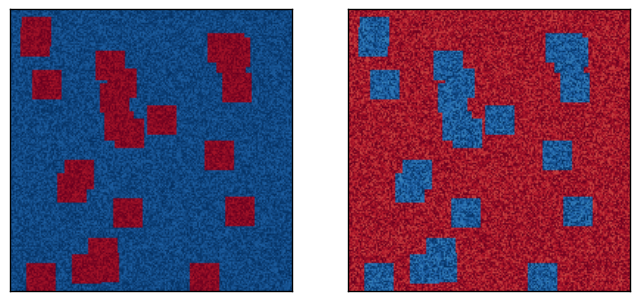

In [6]:
fig = pyplot.figure(figsize=(8,5))
pyplot.subplot(121)
pyplot.imshow(Usave[0,:,:], cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);
pyplot.subplot(122)
pyplot.imshow(Vsave[0,:,:], cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);

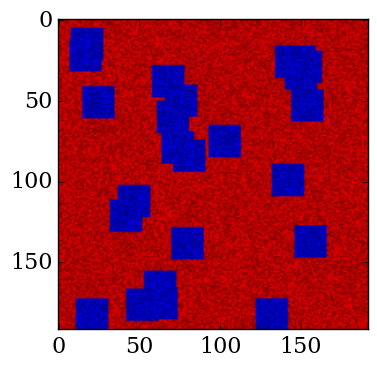

In [7]:
fig = plt.figure()
im = plt.imshow(Usave[0])

def Uanim(i):
    im.set_array(Usave[80*i])
    return  im

anim1 = animation.FuncAnimation(fig,Uanim,frames=range(100), interval=60)

HTML(anim1.to_html5_video())

Avec les différents paramètres nous obtenons donc divers paterns qui reproduisent des modèles de diffusion qui font penser à des cas présents dans la nature. Il est interressant de voir qu'avec des modèles de mathétique simple nous pouvons reproduire des stuctures naturelles complexes en assez bonne approximation.  